In [1]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread
from PIL import Image
import pickle
from skimage.metrics import structural_similarity as ssim

In [2]:
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
def load_data(batch_size=1, is_val = False):
       
        path_SAR = glob('Datasets/v_2/agri/s1/*')
        
        batch_images = np.random.choice(path_SAR, size=batch_size)
        img_res=(256,256)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img_B = imread(img_path)
            img_A = imread(img_path.replace('/s1', '/s2').replace("_s1_","_s2_"))
    
            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
            
        
        imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [4]:
def load_batch(batch_size=1, is_val=False):
        
        path_SAR = glob('Datasets/v_2/agri/s1/*')
        
        n_batches=batch_size
        img_res=(256,256)
        for i in range(n_batches-1):
            batch = path_SAR[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img_B = imread(img)
                img_A = imread(img.replace('/s1', '/s2').replace("_s1_","_s2_"))
                
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)
                
                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

def imread(path):
    
    return np.array(Image.open(path).convert('RGB')).astype(np.float32)
                            

In [5]:
# from PIL import Image

# path_SAR = glob('Datasets/v_2/agri/s1/*')


# # Open an image file
# image = Image.open(path_SAR[1].replace('/s1', '/s2').replace("_s1_","_s2_"))

# # Display the image
# image.show()


### UNNet++ Architecture

<img src="UNet++Arch.jpg" alt="Alt text" width="500" height="300">

In [6]:
def build_generator():
        """U-Net++ Generator"""
        
#         nb_filter = [32,64,128,256,512]
        nb_filter=[8, 16, 32, 64, 128]
        inputs = Input(shape=img_shape)
        
        # X11 block
        conv1_1 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name='problem_node') (inputs)
        conv1_1 = Dropout(0.5) (conv1_1)
        conv1_1 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_1)
        conv1_1 = Dropout(0.5) (conv1_1)
        pool1_1 = MaxPooling2D((2, 2), strides=(2, 2)) (conv1_1)
        
        # X21 block
        conv2_1 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool1_1)
        conv2_1 = Dropout(0.5) (conv2_1)
        conv2_1 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_1)
        conv2_1 = Dropout(0.5) (conv2_1)
        pool2_1 = MaxPooling2D((2, 2), strides=(2, 2)) (conv2_1)
        
        # X12 block
        up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
        conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=3)
        conv1_2 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
        conv1_2 = Dropout(0.5) (conv1_2)
        conv1_2 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
        conv1_2 = Dropout(0.5) (conv1_2)
        
        # X31 block
        conv3_1 = Conv2D(nb_filter[2], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool2_1)
        conv3_1 = Dropout(0.5) (conv3_1)
        conv3_1 = Conv2D(nb_filter[2], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
        conv3_1 = Dropout(0.5) (conv3_1)
        pool3_1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3_1')(conv3_1)

        # X22 block
        up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
        conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=3) #x10
        conv2_2 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
        conv2_2 = Dropout(0.5) (conv2_2)
        conv2_2 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
        conv2_2 = Dropout(0.5) (conv2_2)
        
        # X13 block
        up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
        conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=3)
        conv1_3 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
        conv1_3 = Dropout(0.5) (conv1_3)
        conv1_3 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
        conv1_3 = Dropout(0.5) (conv1_3)
        
        # X41 block
        conv4_1 = Conv2D(nb_filter[3], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3_1)
        conv4_1 = Dropout(0.5) (conv4_1)
        conv4_1 = Conv2D(nb_filter[3], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
        conv4_1 = Dropout(0.5) (conv4_1)
        pool4_1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4_1')(conv4_1)
        
        # X32 block
        up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
        conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
        conv3_2 = Conv2D(nb_filter[2], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
        conv3_2 = Dropout(0.5) (conv3_2)
        conv3_2 = Conv2D(nb_filter[2], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
        conv3_2 = Dropout(0.5) (conv3_2)
        
        # X23 block
        up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
        conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=3)
        conv2_3 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
        conv2_3 = Dropout(0.5) (conv2_3)
        conv2_3 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
        conv2_3 = Dropout(0.5) (conv2_3)
        
        # X14 block
        up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
        conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=3)
        conv1_4 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
        conv1_4 = Dropout(0.5) (conv1_4)
        conv1_4 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
        conv1_4 = Dropout(0.5) (conv1_4)
        
        # X51 block
        conv5_1 = Conv2D(nb_filter[4], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4_1)
        conv5_1 = Dropout(0.5) (conv5_1)
        conv5_1 = Conv2D(nb_filter[4], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
        conv5_1 = Dropout(0.5) (conv5_1)
        
        # X42 block
        up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
        conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
        conv4_2 = Conv2D(nb_filter[3], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
        conv4_2 = Dropout(0.5) (conv4_2)
        conv4_2 = Conv2D(nb_filter[3], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
        conv4_2 = Dropout(0.5) (conv4_2)
        
        # X33 block
        up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
        conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
        conv3_3 = Conv2D(nb_filter[2], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
        conv3_3 = Dropout(0.5) (conv3_3)
        conv3_3 = Conv2D(nb_filter[2], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
        conv3_3 = Dropout(0.5) (conv3_3)
        
        # X24 block
        up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
        conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=3)
        conv2_4 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
        conv2_4 = Dropout(0.5) (conv2_4)
        conv2_4 = Conv2D(nb_filter[1], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
        conv2_4 = Dropout(0.5) (conv2_4)
        
        # X15 block
        up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
        conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
        conv1_5 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
        conv1_5 = Dropout(0.5) (conv1_5)
        conv1_5 = Conv2D(nb_filter[0], (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
        conv1_5 = Dropout(0.5) (conv1_5)
        
#         u7 = UpSampling2D(size=2)(conv1_5) # upsamples to twice the size
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(conv1_5)
        
#         nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

        return Model([inputs], [output_img])

In [7]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d2)

        return Model([img_A, img_B], validity)

In [8]:
# Input shape
img_rows = 256
img_cols = 256
channels = 13
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**2)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

def ssim_loss(valid, fake_A):
    return 1 - tf.image.ssim(valid, fake_A, 1.0)
    

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])

combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

# combined.compile(loss=[ssim_loss], optimizer=optimizer)

In [9]:
def show_images( epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(batch_size=3)
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [10]:
def train( epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)
                
                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            if epoch%10==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(epoch, batch_i)

1/1 [==============================] - 0s 90ms/step
[Epoch 0/1000]  [D loss: 3.317111, acc:  77%] [G loss: 28.785049] time: 0:00:02.874693
1/1 [==============================] - 0s 90ms/step


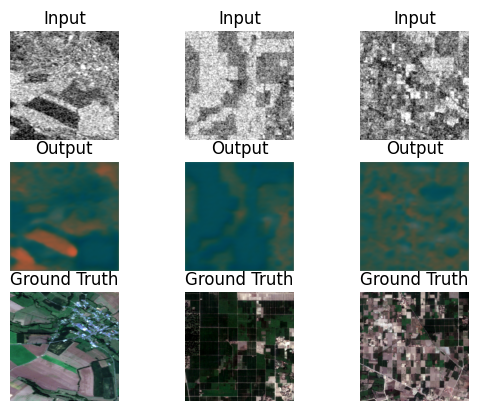

1/1 [==============================] - 0s 50ms/step
[Epoch 10/1000]  [D loss: 3.353017, acc:  74%] [G loss: 28.100842] time: 0:00:30.221347
1/1 [==============================] - 0s 92ms/step


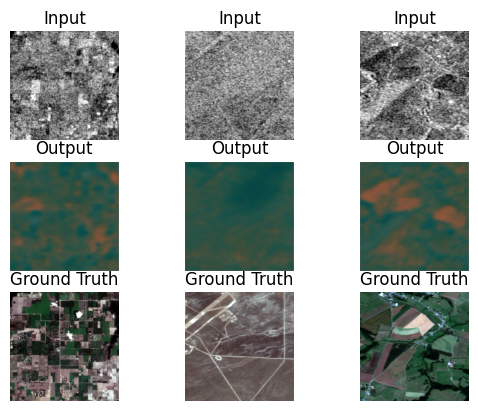

1/1 [==============================] - 0s 54ms/step
[Epoch 20/1000]  [D loss: 3.413711, acc:  74%] [G loss: 26.049580] time: 0:00:56.490141
1/1 [==============================] - 0s 39ms/step


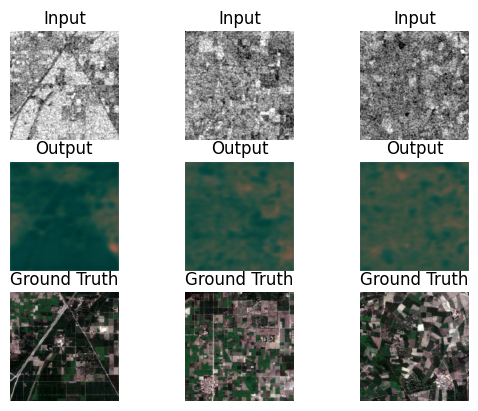

1/1 [==============================] - 0s 71ms/step


In [ ]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    train(epochs=1000, batch_size=4, show_interval=10)

In [12]:
with open('temp2.pkl', 'wb') as file:
        pickle.dump(generator, file)

INFO:tensorflow:Assets written to: ram://51c5956c-13c6-4cc4-b8b9-831e2ff916f8/assets


INFO:tensorflow:Assets written to: ram://51c5956c-13c6-4cc4-b8b9-831e2ff916f8/assets


In [ ]:
with open('temp.pkl', 'rb') as file:
        generator1 = pickle.load(file)

In [ ]:
def show_images_1( epoch, batch_i, generator1):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(batch_size=3)
        fake_A = generator1.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [ ]:
show_images_1(1,1,1,generator1)